Columns in your CSV file: ['observation_date', 'UNRATE']
Error loading data: time data "1948-01-01" doesn't match format "%m/%d/%Y", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

--- Stationarity Test ---
ADF Statistic: -3.9250488137805677
p-value: 0.0018580431880518028
Critical Values:
   1%: -3.437439232284603
   5%: -2.8646696476686477
   10%: -2.5684364181154127


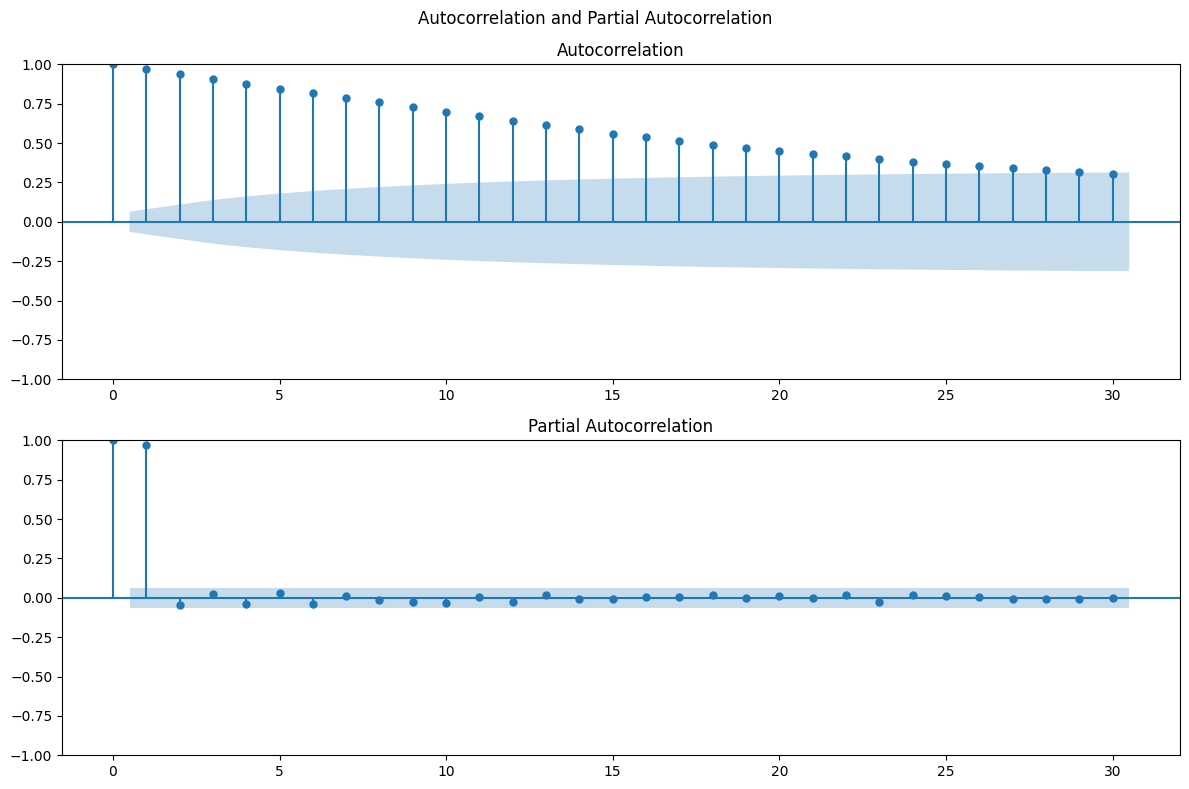


--- Model Summary ---
                               SARIMAX Results                                
Dep. Variable:                 UNRATE   No. Observations:                  927
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -497.887
Date:                Tue, 15 Apr 2025   AIC                           1003.773
Time:                        23:48:23   BIC                           1023.097
Sample:                             0   HQIC                          1011.145
                                - 927                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7599      0.102     -7.447      0.000      -0.960      -0.560
ar.L2         -0.0192      0.013     -1.423      0.155      -0.046       0.007
ma.L1          0.8032      0.

: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- Configuration ---
file_path = 'C:/Users/USER/Downloads/UNRATE.csv'  # Make sure this is your unemployment data file
date_column = 'observation_date'
value_column = 'UNRATE'  # Changed from 'Passengers' to 'UNRATE'
date_format = '%m/%d/%Y'
forecast_steps = 12
arima_order = (2, 1, 1)  # Good starting point for unemployment data

# --- Load and prepare data ---
try:
    df = pd.read_csv(file_path)
    
    # Print column names to verify
    print("Columns in your CSV file:", df.columns.tolist())
    
    df[date_column] = pd.to_datetime(df[date_column], format=date_format)
    df.set_index(date_column, inplace=True)
    df = df.dropna().sort_index()
    
    print("\nData loaded successfully:")
    print(f"Time range: {df.index.min()} to {df.index.max()}")
    print(f"Number of observations: {len(df)}")
    print("\nFirst few rows:")
    print(df.head())
    
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# --- Stationarity Check ---
print("\n--- Stationarity Test ---")
adf_result = adfuller(df[value_column])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

# --- ACF/PACF Plots ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df[value_column], lags=30, ax=ax1)
plot_pacf(df[value_column], lags=30, ax=ax2)
plt.suptitle("Autocorrelation and Partial Autocorrelation")
plt.tight_layout()
plt.show()

# --- ARIMA Modeling ---
try:
    # Fit model
    model = ARIMA(df[value_column], order=arima_order)
    model_fit = model.fit()
    
    print("\n--- Model Summary ---")
    print(model_fit.summary())
    
    # Generate forecast
    forecast = model_fit.get_forecast(steps=forecast_steps)
    forecast_values = forecast.predicted_mean
    conf_int = forecast.conf_int()
    
    # Create forecast index
    last_date = df.index[-1]
    forecast_dates = [last_date + pd.DateOffset(months=x) for x in range(1, forecast_steps+1)]
    forecast_index = pd.DatetimeIndex(forecast_dates)
    
    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'Forecast': forecast_values,
        'Lower CI': conf_int.iloc[:, 0],
        'Upper CI': conf_int.iloc[:, 1]
    }, index=forecast_index)
    
    # --- Plot Results ---
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-36:], df[value_column][-36:], label='Historical Data')
    plt.plot(forecast_df.index, forecast_df['Forecast'], 'r--', label='Forecast')
    plt.fill_between(forecast_df.index, 
                    forecast_df['Lower CI'], 
                    forecast_df['Upper CI'], 
                    color='pink', alpha=0.3, label='95% CI')
    
    plt.title(f'Unemployment Rate Forecast (ARIMA{arima_order})')
    plt.xlabel('Date')
    plt.ylabel('Unemployment Rate (%)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print forecast
    print("\n--- Forecast Results ---")
    print(forecast_df.round(2))
    
    # Residual Analysis
    residuals = model_fit.resid
    plt.figure(figsize=(12, 4))
    residuals.plot()
    plt.title('Model Residuals')
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"\nModeling Error: {e}")
    print("\nTroubleshooting Tips:")
    print("1. Verify your CSV file contains 'observation_date' and 'UNRATE' columns")
    print("2. Try simpler ARIMA orders like (1,1,0)")
    print("3. Check for missing values with df.isnull().sum()")
    print("4. Ensure dates are properly parsed with df.index")